In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# Load the Dogs vs. Cats dataset
train_dataset, info = tfds.load('cats_vs_dogs', split='train[:80%]', with_info=True, as_supervised=True)
test_dataset = tfds.load('cats_vs_dogs', split='train[80%:]', with_info=False, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteKHQLS9/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
# Observe the size of training and test data
len(train_dataset), len(test_dataset)

(18610, 4652)

In [5]:
# Observe the shape of data
for image, label in train_dataset.take(3):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

Image shape: (262, 350, 3), Label: 1
Image shape: (409, 336, 3), Label: 1
Image shape: (493, 500, 3), Label: 1


In [6]:
# Defining hyperparametrs and constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCH_SIZE = 20
# LEARNING_RATE = 0.0001
NUM_CLASSES = info.features['label'].num_classes
TEST_SIZE = len(test_dataset) // 2
VALIDATION_SIZE = len(test_dataset) - TEST_SIZE
TRAIN_SIZE = len(train_dataset)

In [7]:
#preprocess the data
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1] range
    return image, label

# Apply the preprocessing to the datasets
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
# Observe shape of data
for image, label in train_dataset.take(3):
    print(f"After Preprocessing --- Image shape: {image.shape}, Label: {label.numpy()}")

After Preprocessing --- Image shape: (224, 224, 3), Label: 1
After Preprocessing --- Image shape: (224, 224, 3), Label: 1
After Preprocessing --- Image shape: (224, 224, 3), Label: 1


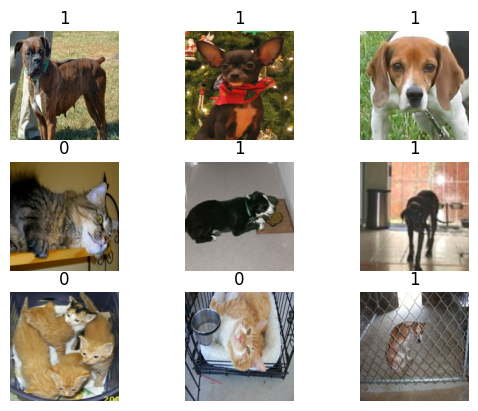

In [9]:
##show some of images with their labels
fig, axes = plt.subplots(3, 3)

for i, (image, label) in enumerate(train_dataset.take(9)):
    row_i = i // 3
    col_i = i % 3
    axes[row_i, col_i].imshow(image)
    axes[row_i, col_i].axis('off')  # Remove axes
    axes[row_i, col_i].set_title(int(label))  # Set title

# plt.tight_layout()
plt.show()

In [10]:
# Data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
# Split the test dataset into validation and test datasets
validation_dataset = test_dataset.take(VALIDATION_SIZE)
test_dataset = test_dataset.skip(VALIDATION_SIZE)

In [12]:
# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Observe the size of training and test data
len(train_dataset), len(test_dataset), len(validation_dataset)

(582, 73, 73)

In [14]:
# Load the Inception-v3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE, 3))
print(inception_model.summary())

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [15]:
#create your model
#dont forget to freeze the pretrained part

# Freeze the layers of the base model
inception_model.trainable = False

# Define the final model
model = models.Sequential([
    inception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # For binary classification (cats vs dogs)
])

In [16]:
# Defining callbacks
callbacks = [
    # Save the best model at the end with respect to val_loss
    keras.callbacks.ModelCheckpoint(filepath="best_model.keras", monitor='val_loss',save_best_only=True, save_weights_only=True),
    # Stop training if model's accuracy goes bad on val_loss for 3 consecutive epochs
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCH_SIZE,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/20
582/582 [==============================] - 70s 97ms/step - loss: 0.1813 - accuracy: 0.9249 - val_loss: 0.0433 - val_accuracy: 0.9905
Epoch 2/20
582/582 [==============================] - 52s 85ms/step - loss: 0.1313 - accuracy: 0.9479 - val_loss: 0.0590 - val_accuracy: 0.9772
Epoch 3/20
582/582 [==============================] - 53s 88ms/step - loss: 0.1296 - accuracy: 0.9490 - val_loss: 0.0406 - val_accuracy: 0.9850
Epoch 4/20
582/582 [==============================] - 53s 89ms/step - loss: 0.1241 - accuracy: 0.9523 - val_loss: 0.0396 - val_accuracy: 0.9880
Epoch 5/20
582/582 [==============================] - 52s 87ms/step - loss: 0.1250 - accuracy: 0.9505 - val_loss: 0.0469 - val_accuracy: 0.9807
Epoch 6/20
582/582 [==============================] - 51s 86ms/step - loss: 0.1249 - accuracy: 0.9513 - val_loss: 0.0416 - val_accuracy: 0.9871
Epoch 7/20
582/582 [==============================] - 52s 86ms/step - loss: 0.1201 - accuracy: 0.9550 - val_loss: 0.0424 - val_accuracy:

In [19]:
# load model and evaluate on test dataset
# print(test_dataset)
model.load_weights("best_model.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

73/73 [==============================] - 8s 73ms/step - loss: 0.0467 - accuracy: 0.9837
Test accuracy: 0.9836629629135132


In [20]:
# Plot the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

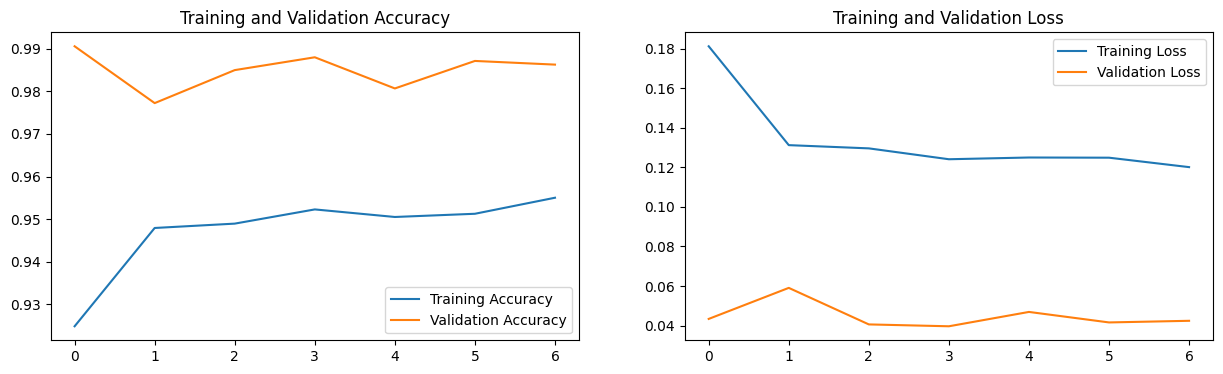

In [22]:
epochs_range = range(7)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()